In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [4]:
df= pd.read_csv('updated_plasmids.csv')
df.head()

,Unnamed: 0,id,sequence,species
0,0,NC_001988.2,GATTGTATAATGCAATTATAGCATATTTAGGAGGTATTTAAAATGA...,Clostridium acetobutylicum ATCC 824
1,1,NC_009131.1,CAGATCAACAAAGGCCACAAACGCCGCTTCGTTTCCTTCCTCGCGG...,Escherichia coli
2,2,NC_019098.1,GTAGAGTTTCAGGGTAACAGGGGATGTTTATGTCGGTTTTCCACAA...,Escherichia coli
3,3,NC_020278.2,CTTCGCGTTGCTCAGTTGTCCAACCCCGGAAACGGGAAAAAGCAAG...,Escherichia coli
4,4,NC_022374.1,ATGGATAAGTTGCTGAACAAAAAGATAAAAGTTAAGCAGTCTAACG...,Escherichia coli


In [8]:
df=df.drop(columns=['id','Unnamed: 0'])

In [9]:
df.head()

,sequence,species
0,GATTGTATAATGCAATTATAGCATATTTAGGAGGTATTTAAAATGA...,Clostridium acetobutylicum ATCC 824
1,CAGATCAACAAAGGCCACAAACGCCGCTTCGTTTCCTTCCTCGCGG...,Escherichia coli
2,GTAGAGTTTCAGGGTAACAGGGGATGTTTATGTCGGTTTTCCACAA...,Escherichia coli
3,CTTCGCGTTGCTCAGTTGTCCAACCCCGGAAACGGGAAAAAGCAAG...,Escherichia coli
4,ATGGATAAGTTGCTGAACAAAAAGATAAAAGTTAAGCAGTCTAACG...,Escherichia coli


In [11]:
def get_kmer(sequence,k=7):
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]

In [12]:
df['kmers']=df['sequence'].apply(lambda x: " ".join(get_kmer(x,k=7)))

In [13]:
df.head()

,sequence,species,kmers
0,GATTGTATAATGCAATTATAGCATATTTAGGAGGTATTTAAAATGA...,Clostridium acetobutylicum ATCC 824,GATTGTA ATTGTAT TTGTATA TGTATAA GTATAAT TATAAT...
1,CAGATCAACAAAGGCCACAAACGCCGCTTCGTTTCCTTCCTCGCGG...,Escherichia coli,CAGATCA AGATCAA GATCAAC ATCAACA TCAACAA CAACAA...
2,GTAGAGTTTCAGGGTAACAGGGGATGTTTATGTCGGTTTTCCACAA...,Escherichia coli,GTAGAGT TAGAGTT AGAGTTT GAGTTTC AGTTTCA GTTTCA...
3,CTTCGCGTTGCTCAGTTGTCCAACCCCGGAAACGGGAAAAAGCAAG...,Escherichia coli,CTTCGCG TTCGCGT TCGCGTT CGCGTTG GCGTTGC CGTTGC...
4,ATGGATAAGTTGCTGAACAAAAAGATAAAAGTTAAGCAGTCTAACG...,Escherichia coli,ATGGATA TGGATAA GGATAAG GATAAGT ATAAGTT TAAGTT...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=10000)

In [52]:
X=tfidf.fit_transform(df['kmers'])

In [53]:
df.head()

,sequence,species,kmers,species_encoded
0,GATTGTATAATGCAATTATAGCATATTTAGGAGGTATTTAAAATGA...,Clostridium acetobutylicum ATCC 824,GATTGTA ATTGTAT TTGTATA TGTATAA GTATAAT TATAAT...,15
1,CAGATCAACAAAGGCCACAAACGCCGCTTCGTTTCCTTCCTCGCGG...,Escherichia coli,CAGATCA AGATCAA GATCAAC ATCAACA TCAACAA CAACAA...,25
2,GTAGAGTTTCAGGGTAACAGGGGATGTTTATGTCGGTTTTCCACAA...,Escherichia coli,GTAGAGT TAGAGTT AGAGTTT GAGTTTC AGTTTCA GTTTCA...,25
3,CTTCGCGTTGCTCAGTTGTCCAACCCCGGAAACGGGAAAAAGCAAG...,Escherichia coli,CTTCGCG TTCGCGT TCGCGTT CGCGTTG GCGTTGC CGTTGC...,25
4,ATGGATAAGTTGCTGAACAAAAAGATAAAAGTTAAGCAGTCTAACG...,Escherichia coli,ATGGATA TGGATAA GGATAAG GATAAGT ATAAGTT TAAGTT...,25


In [22]:
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])
y = df['species_encoded']


In [24]:
y.unique()

array([15, 25, 48, 52, 62, 61,  1, 11, 16, 21,  8, 34,  7, 31, 42, 41, 22,
       10, 44, 43,  0, 47, 39, 36, 28, 37, 32, 60,  6, 57, 33, 12, 51, 20,
       58,  2, 23, 45, 56, 17, 30, 29,  3, 53, 66,  9, 18, 46, 27, 63, 38,
       59, 40,  5, 35, 19, 26,  4, 55, 49, 64, 14, 65, 13, 54, 24, 50])

In [55]:
pd.Series(y).value_counts()

species_encoded
25    1509
48      16
34       6
26       3
10       3
      ... 
14       1
13       1
54       1
24       1
50       1
Name: count, Length: 67, dtype: int64

In [62]:
counts = pd.Series(y).value_counts()
valid_classes = counts[counts > 1].index
mask = df['species_encoded'].isin(valid_classes)

df_filtered = df[mask]

X_filtered = X[mask.values]
y_filtered = df_filtered['species_encoded']

# After filtering rare classes
le = LabelEncoder()
y_filtered_encoded = le.fit_transform(y_filtered)
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered_encoded, test_size=0.3, random_state=42, stratify=y_filtered_encoded
)

# Now train your models with y_train/y_test encoded labels



In [59]:
print("Train classes:", np.unique(y_train))
print("Test classes:", np.unique(y_test))


Train classes: [ 3  8 10 16 17 25 26 34 36 37 44 48 51 65]
Test classes: [ 3 10 17 25 26 34 36 37 48 51]


In [64]:
models={  
    "Random Forest":RandomForestClassifier(),
    "Xgboost":XGBClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred, average='weighted') # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred, average='weighted') # Calculate Recall
    # model_train_rocauc_score = roc_auc_score(y_train, y_train_pred, average= 'micro')


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred,average='weighted') # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred,average='weighted') # Calculate Recall
    # model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    # print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    # print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

/home/prateekpathak/Desktop/eDNA/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Random Forest
Model performance for Training set
- Accuracy: 0.9991
- F1 score: 0.9990
- Precision: 0.9991
- Recall: 0.9991
----------------------------------
Model performance for Test set
- Accuracy: 0.9807
- F1 score: 0.9712
- Precision: 0.9618
- Recall: 0.9807


Xgboost
Model performance for Training set
- Accuracy: 0.9991
- F1 score: 0.9990
- Precision: 0.9991
- Recall: 0.9991
----------------------------------
Model performance for Test set
- Accuracy: 0.9807
- F1 score: 0.9723
- Precision: 0.9642
- Recall: 0.9807




/home/prateekpathak/Desktop/eDNA/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/prateekpathak/Desktop/eDNA/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [71]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.5, min_samples=5, metric='cosine')

In [72]:
dbscan.fit(X)

,eps,0.5
,min_samples,5
,metric,'cosine'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [74]:
df['clusters']=dbscan.labels_

In [79]:
df['clusters'].value_counts()

clusters
 0    1466
-1      51
 1      21
 4      18
 3      17
 2      15
 6       9
 5       7
 7       5
Name: count, dtype: int64

In [77]:
df.tail()

,sequence,species,kmers,species_encoded,clusters
1604,GTGCAGGATGGTGTGACTGATCTTCAACAAACGTATTACCGCCAGG...,Escherichia coli,GTGCAGG TGCAGGA GCAGGAT CAGGATG AGGATGG GGATGG...,25,0
1605,GTGCAGGATGGTGTGACTGATCTTCAACAAACGTATTACCGCCAGG...,Escherichia coli,GTGCAGG TGCAGGA GCAGGAT CAGGATG AGGATGG GGATGG...,25,0
1606,GTGTATAAATACACGGCACAATCGCTCCGCCATAAGCGACAGCTTG...,Escherichia coli,GTGTATA TGTATAA GTATAAA TATAAAT ATAAATA TAAATA...,25,0
1607,GTGTATAAATACACGGCACAATCGCTCCGCCATAAGCGACAGCTTG...,Escherichia coli,GTGTATA TGTATAA GTATAAA TATAAAT ATAAATA TAAATA...,25,0
1608,ATGGAATTGACTTCAAAAGCTATAGGCACGTCCGGTCAGGACGGTA...,Pseudomonas fluorescens R124,ATGGAAT TGGAATT GGAATTG GAATTGA AATTGAC ATTGAC...,50,0


In [80]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12897797 stored elements and shape (1609, 10000)>

In [82]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)

In [87]:
reduced=pca.fit_transform(X)

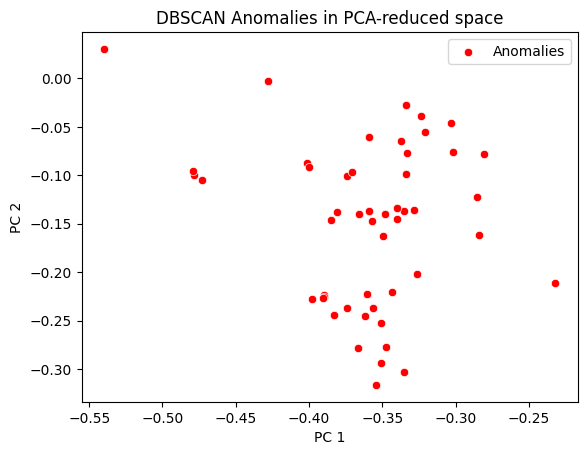

In [90]:
# Filter anomalies from your dataframe
df_anomalies = df[df['clusters'] == -1]

# Get indices of anomalies (useful if you need to subset reduced coordinates)
anomaly_indices = df_anomalies.index

# Plot anomalies in PCA-reduced space
import matplotlib.pyplot as plt
sns.scatterplot(
    x=reduced[anomaly_indices, 0],
    y=reduced[anomaly_indices, 1],
    color='red',
    label='Anomalies'
)
plt.title('DBSCAN Anomalies in PCA-reduced space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()
